<a href="https://colab.research.google.com/github/aakashpaul-2/computer-vision/blob/main/siamese-network-facial-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys, os
from glob import glob
import imageio

from collections import Counter

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
print(tf.__version__)
from keras_preprocessing import image

2.2.0


In [ ]:
!wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip


--2020-07-06 21:04:08--  http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206308 (5.9M) [application/zip]
Saving to: ‘yalefaces.zip’

yalefaces.zip       100%[===================>]   5.92M   304KB/s    in 20s     

2020-07-06 21:04:29 (296 KB/s) - ‘yalefaces.zip’ saved [6206308/6206308]



In [ ]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
  inflating: yalefaces/Readme.txt    
   creating: __MACOSX/
   creating: __MACOSX/yalefaces/
  inflating: __MACOSX/yalefaces/._Readme.txt  
  inflating: yalefaces/subject01.gif  
  inflating: yalefaces/subject01.glasses  
  inflating: yalefaces/subject01.glasses.gif  
  inflating: yalefaces/subject01.happy  
  inflating: yalefaces/subject01.leftlight  
  inflating: yalefaces/subject01.noglasses  
  inflating: yalefaces/subject01.normal  
  inflating: yalefaces/subject01.rightlight  
  inflating: yalefaces/subject01.sad  
  inflating: yalefaces/subject01.sleepy  
  inflating: yalefaces/subject01.surprised  
  inflating: yalefaces/subject01.wink  
  inflating: yalefaces/subject02.centerlight  
  inflating: yalefaces/subject02.glasses  
  inflating: yalefaces/subject02.happy  
  inflating: yalefaces/subject02.leftlight  
  inflating: yalefaces/subject02.noglasses  
  inflating: yalefaces/subject02.normal  
  inflating: yalefaces/subject02.r

In [ ]:
files = glob("yalefaces/subject*")

In [ ]:
files

['yalefaces/subject12.sad',
 'yalefaces/subject08.wink',
 'yalefaces/subject03.centerlight',
 'yalefaces/subject04.happy',
 'yalefaces/subject07.noglasses',
 'yalefaces/subject13.noglasses',
 'yalefaces/subject05.surprised',
 'yalefaces/subject15.leftlight',
 'yalefaces/subject06.sleepy',
 'yalefaces/subject12.glasses',
 'yalefaces/subject07.sad',
 'yalefaces/subject15.wink',
 'yalefaces/subject02.sad',
 'yalefaces/subject13.happy',
 'yalefaces/subject07.sleepy',
 'yalefaces/subject01.glasses',
 'yalefaces/subject15.normal',
 'yalefaces/subject15.centerlight',
 'yalefaces/subject11.wink',
 'yalefaces/subject02.noglasses',
 'yalefaces/subject05.glasses',
 'yalefaces/subject06.happy',
 'yalefaces/subject08.sad',
 'yalefaces/subject03.sleepy',
 'yalefaces/subject10.wink',
 'yalefaces/subject15.sleepy',
 'yalefaces/subject14.sad',
 'yalefaces/subject06.rightlight',
 'yalefaces/subject07.rightlight',
 'yalefaces/subject12.centerlight',
 'yalefaces/subject12.noglasses',
 'yalefaces/subject15

In [ ]:
np.random.shuffle(files)

In [ ]:
N = len(files)
N


166

In [ ]:
H, W = 60, 80

def load_img(filepath):
  # image to numpy array
  img = image.img_to_array(image.load_img(filepath, target_size=[H,W])).astype("uint8")
  return img

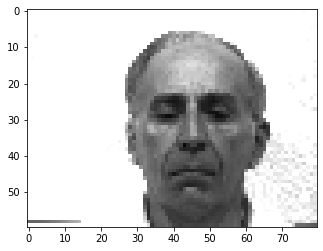

In [ ]:
img = load_img(np.random.choice(files))

plt.imshow(img)
plt.show()

In [ ]:
def to_grayscale(img):
  return img.mean(axis=-1)

In [ ]:
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [ ]:
shape = (N, H, W)
images = np.zeros(shape)

for i, f in enumerate(files):
  img = to_grayscale(load_img(f)) / 255.
  images[i] = img

In [ ]:
images.shape

(166, 60, 80)

In [ ]:
labels = np.zeros(N)
for i, f in enumerate(files):
  filename = f.rsplit("/", 1)[-1]
  subject_num = filename.split(".", 1)[0]

  idx = int(subject_num.replace("subject", "")) - 1
  labels[i] = idx

In [ ]:
labels

array([12.,  8.,  9., 12.,  6.,  6.,  6.,  8.,  3.,  7.,  4.,  5.,  6.,
        3.,  1.,  6., 12.,  6.,  8.,  3.,  8., 12.,  6.,  8.,  1.,  3.,
        5., 11., 10.,  5., 10.,  7.,  9., 12.,  7.,  0., 14., 12., 14.,
       14., 14.,  7., 13.,  6., 10.,  0., 12.,  2.,  0., 10.,  3., 10.,
        0.,  2.,  2.,  7., 12., 14.,  0.,  7., 12.,  8.,  5.,  8.,  1.,
        7.,  1., 13., 11.,  0.,  4.,  6.,  8., 14.,  4.,  9., 13.,  2.,
       13., 10.,  3., 14., 11.,  4.,  5.,  0., 10.,  8., 14.,  9., 10.,
       14.,  3., 13.,  4.,  3.,  1., 13.,  2.,  2.,  9.,  5.,  7.,  2.,
        0.,  5.,  2.,  6.,  0.,  5., 13., 11.,  0., 11., 12., 10., 14.,
        3., 11.,  4.,  9.,  1.,  2.,  9.,  8., 14., 11.,  1., 11., 12.,
       13.,  6.,  1.,  5.,  8.,  9.,  7., 13.,  7.,  4.,  5.,  7.,  0.,
        9.,  1.,  4., 13.,  3.,  5.,  9.,  3.,  4., 10., 10.,  4.,  9.,
       11.,  4., 11.,  2.,  1., 11.,  1., 13.,  0.,  2.])

In [ ]:
label_count = Counter(labels)
label_count

Counter({0.0: 12,
         1.0: 11,
         2.0: 11,
         3.0: 11,
         4.0: 11,
         5.0: 11,
         6.0: 11,
         7.0: 11,
         8.0: 11,
         9.0: 11,
         10.0: 11,
         11.0: 11,
         12.0: 11,
         13.0: 11,
         14.0: 11})

In [ ]:
unique_labels = set(label_count.keys())
unique_labels

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0}

In [ ]:
n_subjects = len(label_count)

In [ ]:
n_subjects

15

In [ ]:
n_test = 3*n_subjects
n_train = N- n_test
n_train

121

In [ ]:
list(img.shape) + [121]

[60, 80, 121]

In [ ]:
train_images = np.zeros([n_train] + list(img.shape))
train_labels = np.zeros(n_train)
test_images = np.zeros([n_test] + list(img.shape))
test_labels = np.zeros(n_test)

In [ ]:
count_so_far = {}
train_idx = 0
test_idx = 0

for img, label in zip(images,labels):
  count_so_far[label] = count_so_far.get(label, 0) + 1

  if count_so_far[label] > 3:
    train_images[train_idx] = img
    train_labels[train_idx] = label
    train_idx += 1

  else:
    test_images[test_idx] = img
    test_labels[test_idx] = label
    test_idx += 1

In [ ]:
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
  if label not in train_label2idx:
    train_label2idx[label] = [i]
  else:
    train_label2idx[label].append(i)

for i, label in enumerate(test_labels):
  if label not in test_label2idx:
    test_label2idx[label] = [i]
  else:
    test_label2idx[label].append(i)

  


In [ ]:
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
  other_indices = set(range(n_train)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      train_positives.append((idx1,idx2))

    for idx2 in other_indices:
      train_negatives.append((idx1, idx2))

for label, indices in test_label2idx.items():
  other_indices = set(range(n_test)) - set(indices)

  for i, idx1 in enumerate(indices):
    for idx2 in indices[i+1:]:
      test_positives.append((idx1,idx2))

    for idx2 in other_indices:
      test_negatives.append((idx1, idx2))

In [ ]:
batch_size = 64

def train_generator():

  n_batches = int(np.ceil(len(train_positives)/batch_size))

  while True:

    np.random.shuffle(train_positives)
    n_samples = batch_size*2
    shape = (n_samples, H,W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = train_positives[i*batch_size : (i+1)*batch_size]

      j=0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 1
        j+=1
      
      neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices))

      for neg in neg_indices:
        idx1, idx2 = train_negatives[neg]
        x_batch_1[j] = train_images[idx1]
        x_batch_2[j] = train_images[idx2]
        y_batch[j] = 0
        j+=1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      x1 = x1.reshape(-1,1,H,W)
      x2 = x2.reshape(-1, 1, H, W)

      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1,x2], y

In [ ]:
def test_generator():

  n_batches = int(np.ceil(len(test_positives)/batch_size))

  while True:

    np.random.shuffle(test_positives)
    n_samples = batch_size*2
    shape = (n_samples, H,W)
    x_batch_1 = np.zeros(shape)
    x_batch_2 = np.zeros(shape)
    y_batch = np.zeros(n_samples)

    for i in range(n_batches):
      pos_batch_indices = test_positives[i*batch_size : (i+1)*batch_size]

      j=0
      for idx1, idx2 in pos_batch_indices:
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 1
        j+=1
      
      neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices))
      for neg in neg_indices:
        idx1, idx2 = test_negatives[neg]
        x_batch_1[j] = test_images[idx1]
        x_batch_2[j] = test_images[idx2]
        y_batch[j] = 0
        j+=1

      x1 = x_batch_1[:j]
      x2 = x_batch_2[:j]
      y = y_batch[:j]

      x1 = x1.reshape(-1,1,H,W)
      x2 = x2.reshape(-1, 1, H, W)

      x1 = torch.from_numpy(x1).float()
      x2 = torch.from_numpy(x2).float()
      y = torch.from_numpy(y).float()

      yield [x1,x2], y

In [ ]:
class SiameseNN(nn.Module):

  def __init__(self, feature_dim):
    super(SiameseNN, self).__init__()

    self.cnn = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(13*18*64, 128),
        nn.ReLU(),
        nn.Linear(128, feature_dim)
    )

  def forward(self, im1, im2):
    feat1 = self.cnn(im1)
    feat2 = self.cnn(im2)

    return torch.norm(feat1-feat2, dim=-1)

In [ ]:
model = SiameseNN(50)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [ ]:
def contrastive_loss(y,t):
  nonmatch = F.relu(1-y)

  return torch.mean(t* y**2 + (1-t)*nonmatch**2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def batch_gd(model, criterion, optimizer, train_gen, test_gen, train_per_epoch, test_per_epoch, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):

    t0  = datetime.now()
    train_loss = []
    steps = 0

    for (x1, x2), targets in train_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(x1, x2)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()
      #print(loss.item())
      train_loss.append(loss.item())
      steps +=1

      if steps >= train_per_epoch:
        break
    
    #print("ok")
    train_loss = np.mean(train_loss)

    test_loss = []
    steps = 0
    for (x1, x2), targets in test_gen:
      x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(x1, x2)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())
      steps +=1
      if steps >= test_per_epoch:
        break
      #print("ok")
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss
    dt = datetime.now() - t0
    #print("dt")

    print("Epoch: {}, Train Loss: {}, Test Loss: {}, Duration: {}".format(it+1, train_loss, test_loss, dt))

  return train_losses, test_losses


In [ ]:
train_steps = int(np.ceil(len(train_positives)/ batch_size))
test_steps = int(np.ceil(len(test_positives)/ batch_size))

train_losses, test_losses = batch_gd(model, contrastive_loss, optimizer, train_generator(), test_generator(), train_steps, test_steps, epochs=20)

Epoch: 1, Train Loss: 0.7120222789900643, Test Loss: 0.34977489709854126, Duration: 0:00:00.213078
Epoch: 2, Train Loss: 0.221821733883449, Test Loss: 0.13514338433742523, Duration: 0:00:00.197886
Epoch: 3, Train Loss: 0.12851972665105546, Test Loss: 0.15170295536518097, Duration: 0:00:00.197289
Epoch: 4, Train Loss: 0.0737551259143012, Test Loss: 0.1155385673046112, Duration: 0:00:00.194005
Epoch: 5, Train Loss: 0.04337039217352867, Test Loss: 0.10043302178382874, Duration: 0:00:00.192699
Epoch: 6, Train Loss: 0.026750808581709862, Test Loss: 0.0891275629401207, Duration: 0:00:00.192489
Epoch: 7, Train Loss: 0.01694460865110159, Test Loss: 0.10203074663877487, Duration: 0:00:00.191973
Epoch: 8, Train Loss: 0.011134599135922534, Test Loss: 0.10020045191049576, Duration: 0:00:00.196112
Epoch: 9, Train Loss: 0.007134645445538419, Test Loss: 0.08787351101636887, Duration: 0:00:00.197443
Epoch: 10, Train Loss: 0.004432522991139974, Test Loss: 0.09788696467876434, Duration: 0:00:00.193548
E

In [ ]:
import torch.nn.functional as F


In [ ]:
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)

  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()